In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D

# Some code (such as the code to do PCA) will generate useless warnings
# We will suppress these warning using the code below
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

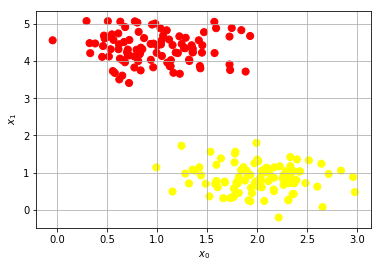

In [34]:
from sklearn.datasets.samples_generator import make_blobs
Xy1 = np.genfromtxt('svmlin.csv',delimiter=',')
X1 = Xy1[:,:2]
y1 = Xy1[:,2]
# Each datapoint in X is tuple of values (x0, x1). Lets plot them 
# on x and y axes respectively.
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='autumn');
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.grid()

## Marginal distance from a hyperplane

Find two lines that classify the red X as two different classes without changin the label of any of the points.

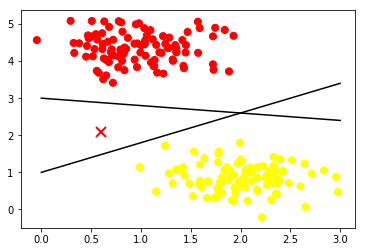

In [43]:
xfit = np.linspace(0, 3)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)


# TODO
# plot two lines that classify X differently

for m, b in [(0.8,1),  (-.2, 3)]:
    plt.plot(xfit, m * xfit + b, '-k')

Find margin for both of you lines

In [44]:
def calculate_margin(m,b,X):
    # TODO
    # find the minimum margin distance to the given line
    margins = []
    for i in X:
        margins.append(np.abs(X[2]+m*X[1]+b)/np.sqrt(m**2+1))# calculate distance for each X
    return np.min(margins)

In [46]:
# TODO
# check the values of minimum margin for your lines
print('margin of the first line: %.3f'%calculate_margin(0.8,1,X1))
print('margin of the second line: %.3f'%calculate_margin(-.2, 3,X1))


margin of the first line: 1.993
margin of the second line: 3.439


Fit a support vector model to the dataset:

In [47]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X1, y1)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Complete the function below for ploting the SVM boundry:

In [48]:
def plot_svc_decision_function(X, y, model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=.5,
               linestyles=['--', '-', '--'])
    
    # plot a black dot over the support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s = 20, facecolor= 'black');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

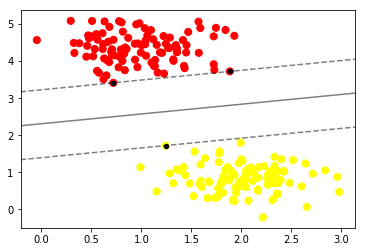

In [49]:
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='autumn')
plot_svc_decision_function(X1, y1 ,model, plot_support=True);

## Kernel SVM

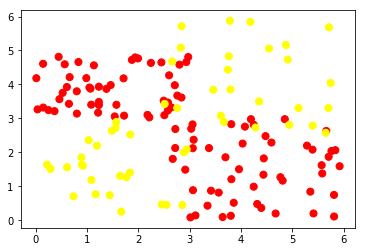

In [50]:
Xy2 = np.genfromtxt('svmnonlin.csv',delimiter=',')
X2 = Xy2[:,:2]
y2 = Xy2[:,2]


plt.scatter(X2[:, 0], X2[:, 1],c=y2, s=50, cmap='autumn')

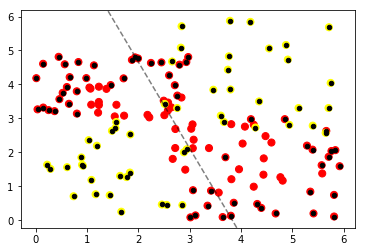

In [51]:
clf = SVC(kernel='linear',C=1) # fit a linear SVM with C=1 
clf.fit(X2,y2)
plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=50, cmap='autumn')
plot_svc_decision_function(X2, y2 ,clf, plot_support=True);

In [52]:
# Computes the weighted sum of kernel values
def compute_f(training_points , test_point, kernel, weights, gamma=1, intercept=0):
    f = 0
    for i in range(len(training_points)):
        trainSample = [training_points[i]] # put the training sample into two diemnsions
        f += weights[i] * kernel(trainSample,test_point,gamma=gamma)# Complete the dual formula  (alpha*y = weights for every training sample)
    return f + intercept

In [53]:
from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel
def surface_kernel(X,y,weights,clf,kernel):
    p = np.linspace(0, 6, 10)
    xx1, xx2 = np.meshgrid(p, p)

    z = float('NaN')*np.ones(xx1.shape)

    intercept = clf.intercept_
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            tst = [[xx1[i, j], xx2[i, j]]]
            z[i, j] = compute_f(X, tst, kernel, weights, gamma=1, intercept=intercept)
    zz = np.empty(y.shape)

    for i in range(X.shape[0]):
        zz[i] = compute_f(X, [X[i,:]], kernel, weights, gamma=1, intercept=intercept)

    return xx1,xx2,z,zz    

In [54]:
def twodprojection(X,model):

    x_min = np.min(X[:, 0])
    y_min = np.min(X[:, 1])
    x_max = np.max(X[:, 0])
    y_max = np.max(X[:, 1])
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    return xx,yy,Z

Fit a svm with RBF kernel to the dataset: (set the kernel value to 'rbf' and gamma to 1)

In [55]:
clf = SVC(kernel='rbf',gamma=1) #Fit a SVM model with RBF kernel and gamma = 1 
clf.fit(X2,y2)
weights = np.zeros((X2.shape[0], 1))
weights[clf.support_] = clf.dual_coef_.T

Plot the 3D projection of the surface of dual function of SVM:

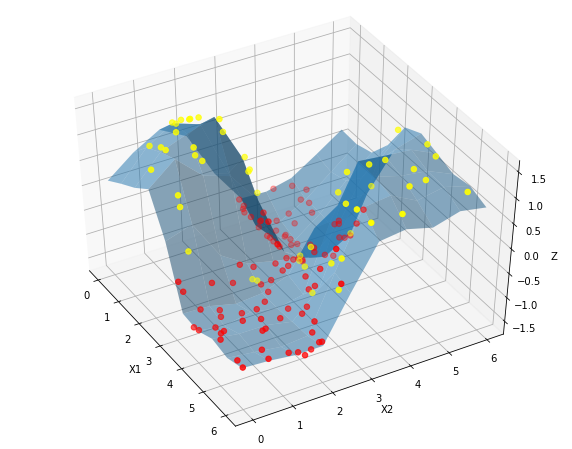

In [56]:
xx1, xx2, z, zz = surface_kernel(X2,y2,weights,clf,rbf_kernel)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx1, xx2, z, alpha=0.5)
ax.view_init(elev=45, azim=-30)
ax.scatter(X2[:, 0], X2[:, 1], zz, s=30,c=y2,cmap='autumn')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Z')
plt.show()

Plot the decision boundaries for RBF kernel:

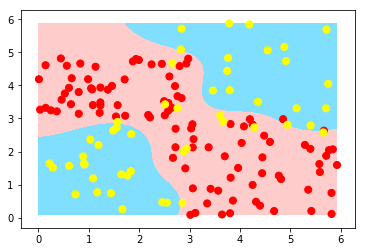

In [57]:
# Plot decision boundary
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFCCCC', '#80dfff'])
xx,yy,Z = twodprojection(X2,clf)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X2[:, 0], X2[:, 1],c=y2, s=50, cmap='autumn')
plt.show()

Fit a svm with RBF kernel to the dataset: (set the kernel value to 'poly' and gamma to 1 and degree to 2)

In [58]:

clf_poly = SVC(kernel='poly',gamma=1,degree=2) # Fit a SVM with second degree polynomial kernel and gamma = 1
clf_poly.fit(X2,y2)
weights = np.zeros((X2.shape[0], 1))
weights[clf_poly.support_] = clf_poly.dual_coef_.T

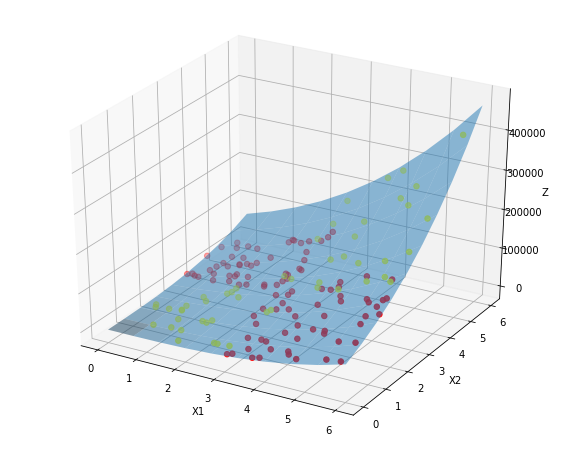

In [59]:
xx1, xx2, z, zz = surface_kernel(X2,y2,weights,clf_poly,polynomial_kernel)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx1, xx2, z, alpha=0.5)
ax.scatter(X2[:, 0], X2[:, 1], zz, s=30,c=y2,cmap='autumn')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Z')
plt.show()

Plot the decision boundaries for Polynomial kernel:

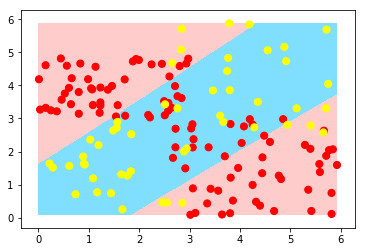

In [60]:
# Plot decision boundary
xx,yy,Z = twodprojection(X2,clf_poly)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X2[:, 0], X2[:, 1],c=y2, s=50, cmap='autumn')

plt.show()

### Tuning the SVM: Softening Margins

Generate the dataset by running the code below:

Text(0, 0.5, '$x_1$')

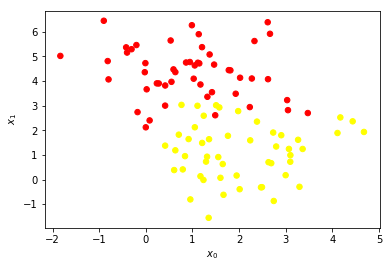

In [61]:
from sklearn.datasets.samples_generator import make_blobs

Xy3 = np.genfromtxt('svmmargin.csv',delimiter=',')
X3 = Xy3[:,:2]
y3 = Xy3[:,2]
plt.scatter(X3[:, 0], X3[:, 1], c=y3, s=30, cmap='autumn');
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")

Fit two different SVMs with C=10 and C=0.1:

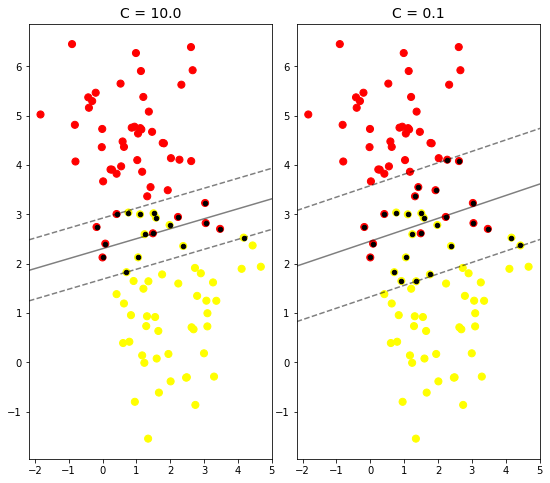

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X3, y3)
    axi.scatter(X3[:, 0], X3[:, 1], c=y3, s=50, cmap='autumn')
    plot_svc_decision_function(X3,y3,model, axi)
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Load the iris dataset and split it into training and test sets and perform cross validation on the training set:
##### Hints: 
Use `train_test_split` and `cross_val_score` from `sklearn.model_selection` to split the dataset and perform cross validation for best value of $C$

In [71]:
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn import datasets
iris = datasets.load_iris()
# TODO
# Split the dataset into training and test set. (75% to 25%)
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.25, random_state=0)
score_list = []
C_list = np.arange(0.1,20,0.05)
# TODO
# perform cross validation on the training set 
for C in C_list: 
    clf = SVC(kernel='linear',C=C).fit(X_train,y_train)
    score = cross_val_score(clf,X_train,y_train,cv=5)
    score_list.append(score.mean())
best_C = C_list[np.argmax(score_list)]
print('The best value for C is :%.3f with score: %.3f'%(best_C,np.max(score_list)))


The best value for C is :2.150 with score: 0.981


Measure the accuracy score on the test set

In [72]:
from sklearn.metrics import accuracy_score
clf = SVC(kernel='linear',C=best_C)
clf.fit(X_train,y_train)
print(accuracy_score(y_test,clf.predict(X_test)))

0.9736842105263158


## Kernel Trick

Complete the implementation of phi:

In [74]:
def phi(x):
    # TODO
    # Complete the implementation
    transformed_x = np.empty(0)
    for i in range(len(x)):
        transformed_x = np.concatenate((transformed_x,x[i]**2))# Power of two terms
    for i in range(1,len(x)):
        for j in range(i):
            if (i!=j):
                transformed_x = np.concatenate((transformed_x,np.sqrt(2)*x[i]*x[j])) # Multipilication Terms
    for i in range(len(x)):
        transformed_x = np.concatenate((transformed_x,np.sqrt(2)*x[i])) #single Terms
    transformed_x = np.concatenate((transformed_x,[1]))
    return transformed_x

Measure the run time in normal way:

In [75]:
import timeit
np.random.seed(3)
run_time = []
kernel_values = []
for d in range(1,500,100):
    start = timeit.default_timer()

    x = np.random.uniform(0,100,[d,1])
    z = np.random.uniform(0,100,[d,1])
    x_k = phi(x)
    z_k = phi(z)
    kernel_values.append(np.dot(x_k,z_k)) # the value of K(x,z) using phi
    
    stop = timeit.default_timer()
    run_time.append(stop - start)

Measure the run time for Kernel Trick:

In [80]:
np.random.seed(3)
run_time_trick = []
kernel_values_trick = []
for d in range(1,500,100):
    start = timeit.default_timer()

    x = np.random.uniform(0,100,[d,1])
    z = np.random.uniform(0,100,[d,1])
    # TODO
    kernel_values_trick.append((1+np.matmul(x.T,z)**2)) # the value of K(x,z) using kernel trick 
    
    stop = timeit.default_timer()
    run_time_trick.append(stop - start)

Plot the run times:

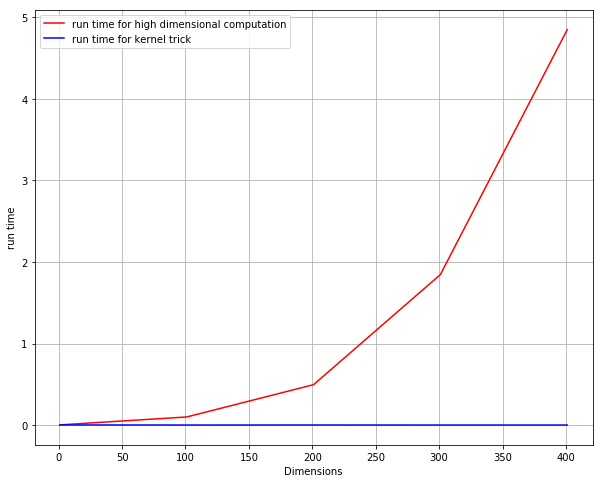

In [81]:
plt.figure(figsize=(10,8))
plt.plot(range(1,500,100),run_time,'R',label='run time for high dimensional computation')
plt.plot(range(1,500,100),run_time_trick,'B',label='run time for kernel trick')
plt.grid()
plt.xlabel('Dimensions')
plt.ylabel('run time')
plt.legend()

Compare the values of the kernel:

In [82]:
kernel_values

[15221416.30344801,
 56473864513.453094,
 217929573630.44968,
 645594747110.2302,
 1060492455318.658]

In [83]:
kernel_values_trick

[array([[15213615.37673979]]),
 array([[5.64733892e+10]]),
 array([[2.1792864e+11]]),
 array([[6.4559314e+11]]),
 array([[1.0604904e+12]])]